In [1]:
!pip install nsepython
!pip install plotly
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Stock Name  INFY


Choose indicators to plot (comma-separated):
1: SMA (20, 50)
2: EMA (20)
3: RSI
4: Bollinger Bands
5: MACD
6: OBV
7: Select All


Enter your choices (e.g., 1,3,5 or 7 for all):  1


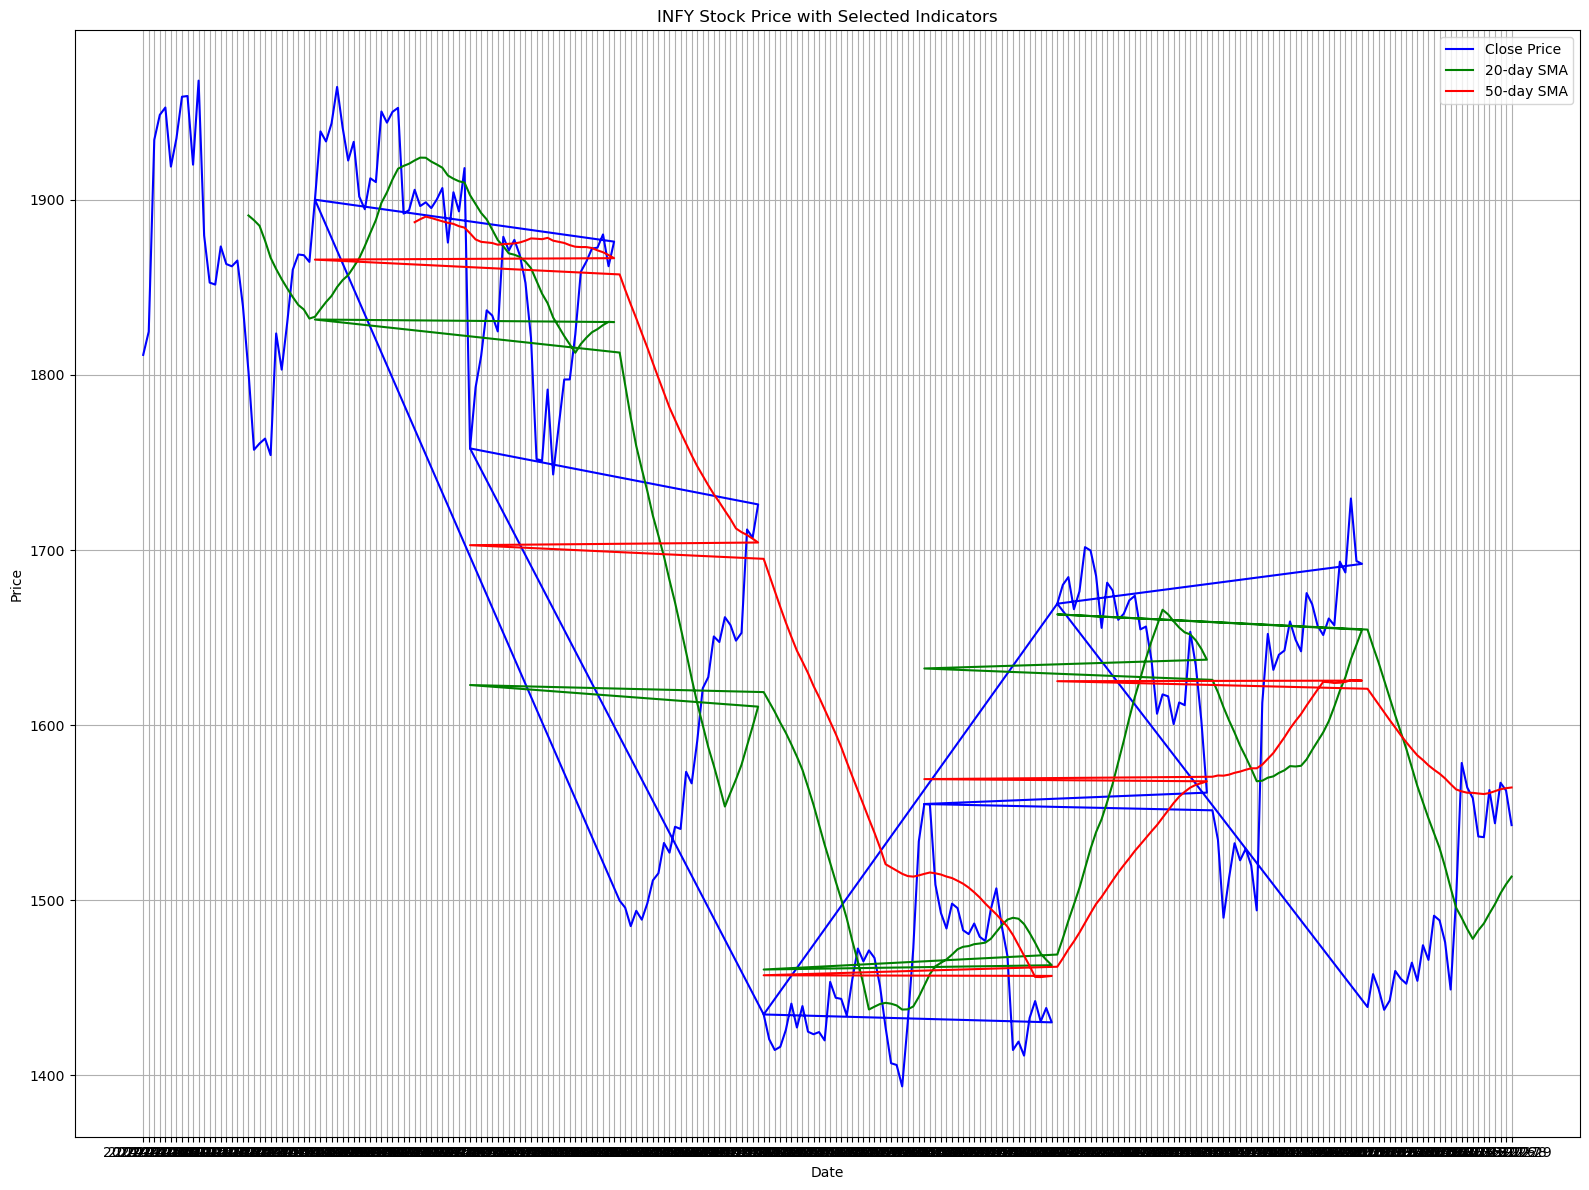

In [2]:
from nsepython import *
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import datetime

# Fetch historical data for a stock
symbol = input("Stock Name ")#"RELIANCE"  # Replace with your desired stock symbol
#data = nsefetch(f"https://www.nseindia.com/api/historical/cm/equity?symbol={symbol}&series=[%22EQ%22]&from=2023-01-01&to=2023-12-31")
#data= nse_quote(symbol)

# Fetch stock details
end_date = datetime.datetime.now().strftime("%d-%m-%Y")
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%d-%m-%Y")
series = "EQ"
#print(data)
# Convert data to DataFrame
df= equity_history(symbol.upper(), series, start_date, end_date)

df['date'] = df['CH_TIMESTAMP']
df['close'] = df['CH_CLOSING_PRICE']
df['volume'] = df['CH_TOT_TRADED_QTY']

# Define indicator calculation functions
def calculate_sma():
    df['SMA_20'] = df['CH_CLOSING_PRICE'].rolling(window=20).mean()
    df['SMA_50'] = df['CH_CLOSING_PRICE'].rolling(window=50).mean()

def calculate_ema():
    df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()

def calculate_rsi():
    delta = df['close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

def calculate_bollinger_bands():
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['std_dev'] = df['close'].rolling(window=20).std()
    df['Upper_Band'] = df['SMA_20'] + (2 * df['std_dev'])
    df['Lower_Band'] = df['SMA_20'] - (2 * df['std_dev'])

def calculate_macd():
    df['MACD'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

def calculate_obv():
    df['OBV'] = 0
    df['OBV'] = df.apply(lambda row: row['volume'] if row['close'] > row['close'].shift(1) 
                         else -row['volume'] if row['close'] < row['close'].shift(1) else 0, axis=1).cumsum()

# Display indicator options
print("Choose indicators to plot (comma-separated):")
print("1: SMA (20, 50)")
print("2: EMA (20)")
print("3: RSI")
print("4: Bollinger Bands")
print("5: MACD")
print("6: OBV")
print("7: Select All")

choice = input("Enter your choices (e.g., 1,3,5 or 7 for all): ").split(",")

# Check if 'All' is selected
if "7" in choice:
    choice = ["1", "2", "3", "4", "5", "6"]

# Calculate selected indicators
if "1" in choice:
    calculate_sma()
if "2" in choice:
    calculate_ema()
if "3" in choice:
    calculate_rsi()
if "4" in choice:
    calculate_bollinger_bands()
if "5" in choice:
    calculate_macd()
if "6" in choice:
    calculate_obv()

# Plotting
plt.figure(figsize=(16, 12))

# Plot Close Price and Overlay Selected Indicators
plt.plot(df['date'], df['close'], label='Close Price', color='blue')

if "1" in choice:
    plt.plot(df['date'], df['SMA_20'], label='20-day SMA', color='green')
    plt.plot(df['date'], df['SMA_50'], label='50-day SMA', color='red')
if "2" in choice:
    plt.plot(df['date'], df['EMA_20'], label='20-day EMA', color='purple')
if "4" in choice:
    plt.plot(df['date'], df['Upper_Band'], label='Upper Bollinger Band', color='orange', linestyle='dashed')
    plt.plot(df['date'], df['Lower_Band'], label='Lower Bollinger Band', color='orange', linestyle='dashed')

plt.title(f"{symbol} Stock Price with Selected Indicators")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()

fig = go.Figure(data=[
    go.Candlestick(
        x=df['CH_TIMESTAMP'],
        open=df['CH_OPENING_PRICE'],
        high=df['CH_TRADE_HIGH_PRICE'],
        low=df['CH_TRADE_LOW_PRICE'],
        close=df['CH_CLOSING_PRICE'],
        name='Price'
    ),
    go.Bar(
        x=df['CH_TIMESTAMP'],
        y=df['CH_TOT_TRADED_QTY'],
        name='Volume',
        marker=dict(color='blue'),
        opacity=0.3,
        yaxis='y2'
    )
])


# Additional subplots for specific indicators
if "3" in choice or "5" in choice or "6" in choice:
    plt.figure(figsize=(16, 8))

    if "3" in choice:
        plt.plot(df['date'], df['RSI'], label='RSI', color='cyan')
        plt.axhline(70, color='red', linestyle='dashed', label='Overbought')
        plt.axhline(30, color='green', linestyle='dashed', label='Oversold')
        plt.title("RSI")
        plt.legend()
        plt.grid()

    if "5" in choice:
        plt.plot(df['date'], df['MACD'], label='MACD', color='blue')
        plt.plot(df['date'], df['Signal_Line'], label='Signal Line', color='orange')
        plt.title("MACD")
        plt.legend()
        plt.grid()

    if "6" in choice:
        plt.plot(df['date'], df['OBV'], label='OBV', color='magenta')
        plt.title("On-Balance Volume (OBV)")
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()
